<html><link rel="icon" href="https://www.sas.com/etc/designs/saswww/favicon.ico">
    <HEAD><center><img src="https://blogs.sas.com/content/sgf/files/2017/10/sas-viya-logo-cloud-08.png" alt="logo" style="width:30%;height:30%";/></center>
   </HEAD>
     <BODY class='body'>
     <h1><center>Exploratory Data Analysis for HMEQ Dataset</h1>
	 <h2><center>This report analyses key summary statistics for the HMEQ dataset in order to evaluate best features for building a predictive model</h2>
	 <br></br>

# Connect our SAS Session to CAS

In [ ]:
ods graphics on / noborder width=600 height=500;
ods listing image_dpi=500;

options cashost='myserver.demo.com' casport=5570;
cas mysess;
libname casuser cas;

# View a sample of the data

In [2]:
proc print data=casuser.hmeq (obs=5) noobs;run;

BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,BAD_CLASS
1,1100,25860,39025,HomeImp,Other,10.5,0,0,94.367,1,9,.,1
1,1300,70053,68400,HomeImp,Other,7.0,0,2,121.833,0,14,.,1
1,1500,13500,16700,HomeImp,Other,4.0,0,0,149.467,1,10,.,1
1,1500,.,.,,,.,.,.,.,.,.,.,1
0,1700,97800,112000,HomeImp,Office,3.0,0,0,93.333,0,14,.,0


##### We have a mix of categorical and numeric inputs, with incomplete observations in the dataset

# View Summary Statistics

In [3]:
proc means data=casuser.hmeq chartype mean std min max median n nmiss 
vardef=df qmethod=os;
var LOAN MORTDUE VALUE YOJ DEROG DELINQ CLAGE NINQ CLNO DEBTINC;
by BAD_CLASS;
run;


Variable,Mean,Std Dev,Minimum,Maximum,Median,N,N Miss
LOAN MORTDUE VALUE YOJ DEROG DELINQ CLAGE NINQ CLNO DEBTINC,19028.11 74829.25 102595.92 9.1549410 0.1342169 0.2451325 187.0023549 1.0327491 21.3170361 33.2531286,11115.76 43584.99 52748.39 7.6760335 0.5144903 0.6741240 84.4652169 1.5313223 9.6826008 6.9474817,1700.00 2619.00 8000.00 0 0 0 0.4867115 0 0 0.7202950,89900.00 371003.00 471827.00 36.0000000 6.0000000 5.0000000 649.7471044 11.0000000 56.0000000 45.5698427,16900.00 66839.00 90659.00 7.0000000 0 0 180.4157867 1.0000000 20.0000000 34.5416714,4771 4359 4764 4321 4150 4263 4541 4336 4602 4290,0 412 7 450 621 508 230 435 169 481
Variable,Mean,Std Dev,Minimum,Maximum,Median,N,N Miss
LOAN MORTDUE VALUE YOJ DEROG DELINQ CLAGE NINQ CLNO DEBTINC,16922.12 69460.45 98172.85 8.0278025 0.7078040 1.2291853 150.1901834 1.7827648 21.2112676 39.3876449,11418.46 47588.19 74339.82 7.1007348 1.4683809 1.9029614 84.9522863 2.2469764 11.8129808 17.7235863,1100.00 2063.00 8800.00 0 0 0 0 0 0 0.5244992,77400.00 399550.00 855909.00 41.0000000 10.0000000 15.0000000 1168.23 17.0000000 71.0000000 203.3121487,14900.00 60279.00 82000.00 6.0000000 0 0 132.8666667 1.0000000 20.0000000 38.0797618,1189 1083 1084 1124 1102 1117 1111 1114 1136 403,0 106 105 65 87 72 78 75 53 786


##### Our positive class only represents around 20% of the dataset. All numeric attributes appear to have a wide range of values. There may be outliers in the dataset as the mean and median is often quite different

# Explore Linear Correlation between Numeric Attributes


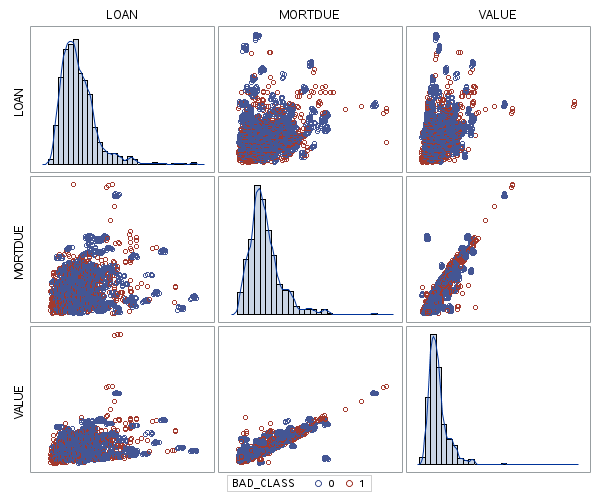

In [4]:
proc sgscatter data=casuser.hmeq; 
matrix Loan Mortdue Value /group=BAD_CLASS diagonal=(histogram kernel);
run;


##### There appears to be collinearity between the outstanding Mortgage amount and Value amount. The numeric attributes are skewed and may benefit from transformation. There is no visible difference between the scatter plots for the BAD class

# Frequencies by Category


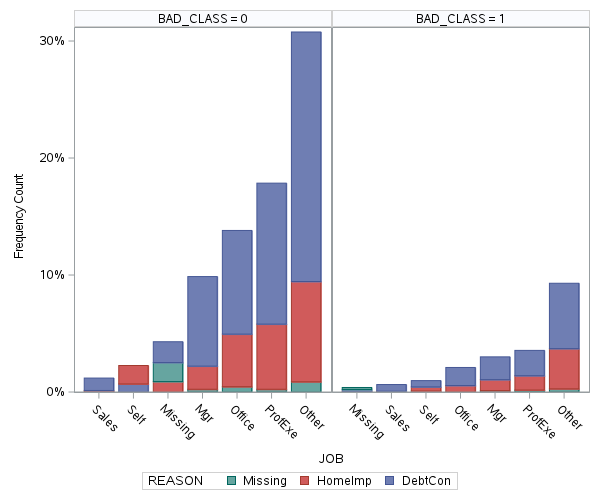

In [5]:
data casuser.hmeq_freq_input;
set casuser.hmeq;
if reason = '' then reason='Missing';
if job = '' then job = 'Missing';
run;

proc freq data=casuser.hmeq_freq_input noprint;
tables REASON * JOB  / nocum out=casuser.freq  outexpect sparse;
by BAD_CLASS;
run;

proc sgpanel data=casuser.freq;
panelby bad_class;
vbar job /
    response=count
    stat=percent
 group=reason
CATEGORYORDER=RESPASC;
run;


##### For both event levels most observations list OTHER as job role. In both cases the majority of loans are for Debt Consolidation. Missing values do not appear related to the event level so may be missing at random.

# Explore Information Gain


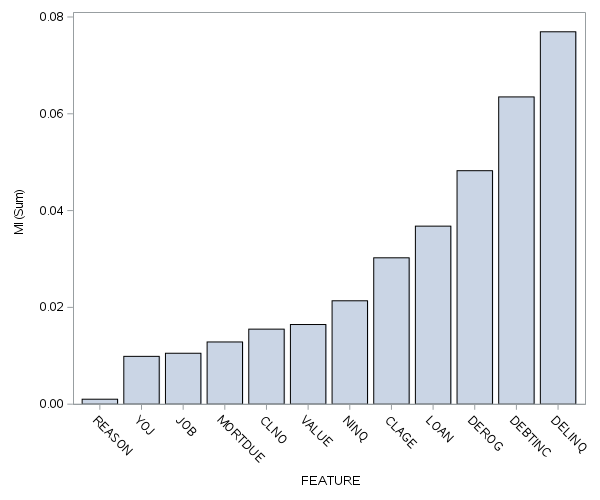

In [6]:
PROC SQL ;
CREATE TABLE WORK.BARPLOT AS select
CASE WHEN FIRSTVARIABLE = 'BAD' THEN SECONDVARIABLE ELSE FIRSTVARIABLE END AS FEATURE,
MI FROM CASUSER.HMEQ_CORRELATION WHERE FIRSTVARIABLE = 'BAD' OR SECONDVARIABLE='BAD';
QUIT;

proc sgplot data=WORK.BARPLOT;
  vbar FEATURE /
    response=MI
    stat=SUM
CATEGORYORDER=RESPASC;
run;

##### DELINQ DEROG and DEBTINC appear to have them most explanatory value for BAD. The job and reason for the loan appears to not be very important, which is consistent with our frequency plot